In [80]:
import cv2
from util import *
from Image_registration import registration
import glob
import os
import matplotlib.pyplot as plt

In [90]:
# Rutas de las imágenes
image_0_path = "Cameras/captures/thermal_rectified/thermal_20241107_163226.png"
image_1_path = "Cameras/captures/visible/left_rect/LEFT_visible_20241107_163226.png"

In [91]:
image_warped, matches, scores, error = registration.procesar_imagenes(ruta_imagen0=image_0_path, ruta_imagen1=image_1_path, threshold=250)


Dispositivo utilizado: cuda
No se aplicará ningún filtro.
No se aplicará ningún filtro.
shape: (480, 640, 3) - Matches: 254 - Score: 254


In [92]:
#El error medio máximo sería alrededor de 800 píxeles para un par de imagenes de 640x480.
error

9.265406396890514

In [93]:
reliable_points = []
for i in range(len(matches)):
    score_tmp = scores[i].item()
    if score_tmp >= 0.75:
        reliable_points.append(matches[i])

In [94]:
print("Los puntos arriba de un umbral de 0.75 son:")
len(reliable_points)

Los puntos arriba de un umbral de 0.75 son:


14

In [95]:


def show_differences(image_0: np.ndarray, image_1: np.ndarray):
    """
    Fusiona dos imágenes y muestra las diferencias utilizando matplotlib.

    Parámetros:
    - image_0 (np.ndarray): Primera imagen (por ejemplo, una imagen RGB).
    - image_1 (np.ndarray): Segunda imagen (por ejemplo, una imagen en escala de grises).

    La función convierte la segunda imagen a RGB, asegura que ambas imágenes tengan el mismo tamaño,
    las fusiona sumando sus valores de píxeles y muestra la imagen resultante en el notebook.
    """
    # Verificar si image_1 es una imagen en escala de grises (2 dimensiones)
    if len(image_1.shape) == 2:
        # Convertir la imagen en escala de grises a RGB
        image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_GRAY2RGB)
    elif len(image_1.shape) == 3 and image_1.shape[2] == 1:
        # Si image_1 tiene un solo canal pero en formato 3D, también convertir a RGB
        image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_GRAY2RGB)
    else:
        # Si image_1 ya tiene 3 canales, asumir que está en BGR y convertir a RGB
        image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

    # Verificar si image_0 también está en BGR y convertir a RGB si es necesario
    if len(image_0.shape) == 3 and image_0.shape[2] == 3:
        image_0_rgb = cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB)
    else:
        image_0_rgb = image_0.copy()

    # Asegurarse de que ambas imágenes tengan el mismo tamaño
    if image_0_rgb.shape != image_1_rgb.shape:
        print(f"Las resoluciones no son iguales.\nimage_0: {image_0_rgb.shape}\nimage_1: {image_1_rgb.shape}")
        image_1_rgb = cv2.resize(image_1_rgb, (image_0_rgb.shape[1], image_0_rgb.shape[0]))

    # Fusionar las imágenes sumando sus valores de píxeles
    # Asegurarse de que el tipo de datos sea adecuado para evitar desbordamientos
    merged_image = cv2.add(image_0_rgb.astype(np.uint16), image_1_rgb.astype(np.uint16))
    merged_image = np.clip(merged_image, 0, 255).astype(np.uint8)

    # Mostrar la imagen fusionada usando matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(merged_image)
    plt.title('Registered Differences')
    plt.axis('off')  # Ocultar los ejes para una mejor visualización
    plt.show()



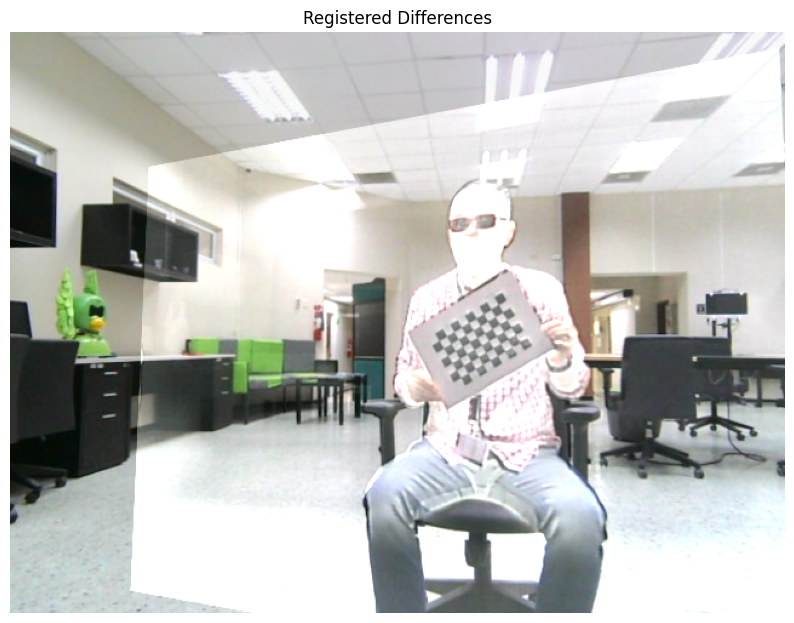

In [64]:
# # Fusionar las imágenes y mostrar las diferencias
image_1 = cv2.imread(image_1_path, cv2.IMREAD_COLOR)

show_differences(image_1, image_warped)